In [1]:
import pandas as pd
import numpy as np
from custom_data import CustomDataGen

In [2]:
df = pd.read_csv("torronto_df.csv")
df.output = df.output.astype(np.int32)
df.center_index = df.center_index.apply(eval).apply(np.array)

In [3]:
df.head()

,Unnamed: 0,image_file,fixation_file,image_size,center_index,output
0,0,data/toronto/fixdens/images/1.jpg,data/toronto/fixdens/output/d1.jpg,"(681, 511)","[376, 367]",1
1,1,data/toronto/fixdens/images/1.jpg,data/toronto/fixdens/output/d1.jpg,"(681, 511)","[380, 351]",1
2,2,data/toronto/fixdens/images/1.jpg,data/toronto/fixdens/output/d1.jpg,"(681, 511)","[375, 349]",1
3,3,data/toronto/fixdens/images/1.jpg,data/toronto/fixdens/output/d1.jpg,"(681, 511)","[383, 351]",1
4,4,data/toronto/fixdens/images/1.jpg,data/toronto/fixdens/output/d1.jpg,"(681, 511)","[375, 351]",1


In [4]:
train= df.sample(frac=0.7,random_state=200) #random state is a seed value
test= df.drop(train.index)

In [5]:
batch_size = 8
target_size = (400,400)

In [6]:
traingen = CustomDataGen(train,
                             X_col={
                                 'path': 'image_file',
                                 'center': 'center_index'
                             },
                             y_col={
                                 'output': 'output'
                             },
                             batch_size=batch_size,
                             input_size=target_size)
valgen = CustomDataGen(test,
                             X_col={
                                 'path': 'image_file',
                                 'center': 'center_index'
                             },
                             y_col={
                                 'output': 'output'
                             },
                             batch_size=batch_size,
                             input_size=target_size)

In [7]:
# x, y = traingen[0];

In [8]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Add
from tensorflow.keras.models import Model
import tensorflow as tf

In [9]:
def initialize_base_network(stream_name, patch_size=(42,42,3)):
    input = Input(shape=(patch_size), name='patch_input')
    x = Conv2D(96, 7, activation='relu', name='conv_1')(input)
    x = MaxPool2D((2, 2))(x)
    x = Conv2D(160, 3, activation='relu', name='conv_2')(x)
    x = MaxPool2D((2, 2))(x)
    x = Conv2D(288, 3, activation='relu', name='conv_3')(x)
    x = MaxPool2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu', name='dense_stream')(x)
    return Model(inputs=input, outputs=x, name=stream_name)

In [10]:
input_image_1 = Input(shape=(
    42,
    42,
    3,
), name='input_img_1')
stream_s1 = initialize_base_network(stream_name='stream_1')
vec_output_a = stream_s1(input_image_1)

input_image_2 = Input(shape=(
    42,
    42,
    3,
), name='input_img_2')
stream_s2 = initialize_base_network(stream_name='stream_2')
vec_output_b = stream_s2(input_image_2)

input_image_3 = Input(shape=(
    42,
    42,
    3,
), name='input_img_3')
stream_s3 = initialize_base_network(stream_name='stream_3')
vec_output_c = stream_s3(input_image_3)

In [11]:
added = Add(name='add_streams')([vec_output_a, vec_output_b, vec_output_c])
x = Dense(512, activation='relu', name='dense_all')(added)
output = Dense(1, activation='sigmoid', name='output')(x)

In [12]:
model = Model([input_image_1, input_image_2, input_image_3], output, name='mr-cnn')

In [13]:
model.summary()

Model: "mr-cnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img_1 (InputLayer)       [(None, 42, 42, 3)]  0           []                               
                                                                                                  
 input_img_2 (InputLayer)       [(None, 42, 42, 3)]  0           []                               
                                                                                                  
 input_img_3 (InputLayer)       [(None, 42, 42, 3)]  0           []                               
                                                                                                  
 stream_1 (Functional)          (None, 512)          1895232     ['input_img_1[0][0]']            
                                                                                             

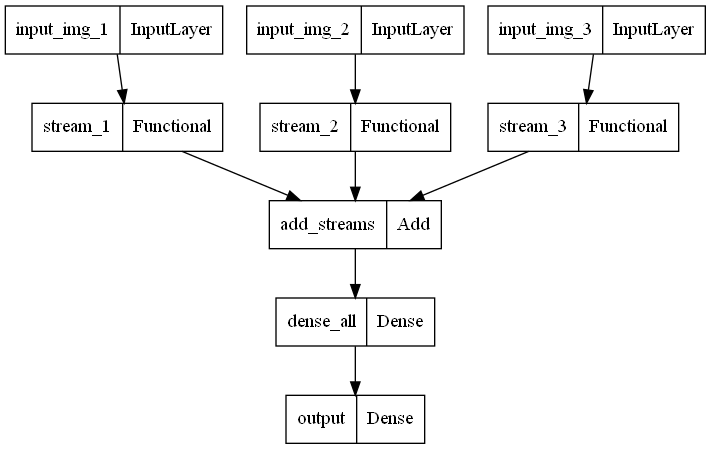

In [14]:
tf.keras.utils.plot_model(model)

In [15]:
adam = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam'
)
sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

In [16]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
cce = tf.keras.losses.CategoricalCrossentropy()

In [17]:
model.compile(optimizer=adam,
                   loss=bce,
                   metrics=['accuracy'])

In [18]:
model.fit(traingen, validation_data=valgen, epochs=5)

Epoch 1/5
(484, 484, 3) 589 157 [ 73 505]


InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  ValueError: height must be >= target + offset.
Traceback (most recent call last):

  File "C:\Users\sktsa\tflow\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "C:\Users\sktsa\tflow\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\sktsa\tflow\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1004, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\sktsa\tflow\lib\site-packages\keras\engine\data_adapter.py", line 830, in wrapped_generator
    for data in generator_fn():

  File "C:\Users\sktsa\tflow\lib\site-packages\keras\engine\data_adapter.py", line 956, in generator_fn
    yield x[i]

  File "c:\Users\sktsa\Projects\coursera-advance-tensorflow-techniques\test\custom_data.py", line 75, in __getitem__
    X, y = self.__get_data(batches)

  File "c:\Users\sktsa\Projects\coursera-advance-tensorflow-techniques\test\custom_data.py", line 62, in __get_data
    X1_batch = np.asarray([self.__get_input_img(x, y, (400,400)) for x, y in zip(path_batch, center_loc_batch)])

  File "c:\Users\sktsa\Projects\coursera-advance-tensorflow-techniques\test\custom_data.py", line 62, in <listcomp>
    X1_batch = np.asarray([self.__get_input_img(x, y, (400,400)) for x, y in zip(path_batch, center_loc_batch)])

  File "c:\Users\sktsa\Projects\coursera-advance-tensorflow-techniques\test\custom_data.py", line 45, in __get_input_img
    image_arr = tf.image.crop_to_bounding_box(image_arr, ymin, xmin, h, w).numpy()

  File "C:\Users\sktsa\tflow\lib\site-packages\tensorflow\python\util\traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "C:\Users\sktsa\tflow\lib\site-packages\tensorflow\python\ops\image_ops_impl.py", line 81, in _assert
    raise ex_type(msg)

ValueError: height must be >= target + offset.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_6]]
  (1) INVALID_ARGUMENT:  ValueError: height must be >= target + offset.
Traceback (most recent call last):

  File "C:\Users\sktsa\tflow\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "C:\Users\sktsa\tflow\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\sktsa\tflow\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1004, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\sktsa\tflow\lib\site-packages\keras\engine\data_adapter.py", line 830, in wrapped_generator
    for data in generator_fn():

  File "C:\Users\sktsa\tflow\lib\site-packages\keras\engine\data_adapter.py", line 956, in generator_fn
    yield x[i]

  File "c:\Users\sktsa\Projects\coursera-advance-tensorflow-techniques\test\custom_data.py", line 75, in __getitem__
    X, y = self.__get_data(batches)

  File "c:\Users\sktsa\Projects\coursera-advance-tensorflow-techniques\test\custom_data.py", line 62, in __get_data
    X1_batch = np.asarray([self.__get_input_img(x, y, (400,400)) for x, y in zip(path_batch, center_loc_batch)])

  File "c:\Users\sktsa\Projects\coursera-advance-tensorflow-techniques\test\custom_data.py", line 62, in <listcomp>
    X1_batch = np.asarray([self.__get_input_img(x, y, (400,400)) for x, y in zip(path_batch, center_loc_batch)])

  File "c:\Users\sktsa\Projects\coursera-advance-tensorflow-techniques\test\custom_data.py", line 45, in __get_input_img
    image_arr = tf.image.crop_to_bounding_box(image_arr, ymin, xmin, h, w).numpy()

  File "C:\Users\sktsa\tflow\lib\site-packages\tensorflow\python\util\traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "C:\Users\sktsa\tflow\lib\site-packages\tensorflow\python\ops\image_ops_impl.py", line 81, in _assert
    raise ex_type(msg)

ValueError: height must be >= target + offset.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_2676]

In [ ]:
x, y = traingen[14]
model.predict_step((x,y))